In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download eeshawn/flickr30k

100% 4.07G/4.08G [00:50<00:00, 135MB/s]
100% 4.08G/4.08G [00:50<00:00, 86.0MB/s]


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

In [ ]:
# Desired image dimensions
IMAGE_SIZE = (224, 224)

# Vocabulary size
VOCAB_SIZE = 10000

#sequence length is restricted to 25
SEQ_LENGTH = 25

BATCH_SIZE = 32
EPOCHS = 2 #pass through the data
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
from itertools import islice

In [ ]:
import os
import zipfile

def load_captions_data(zip_filename):

    # Extract the contents of the zip file
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall('flickr30k_data')  # Extract to a directory named 'flickr30k_data'

    caption_file_path = os.path.join('flickr30k_data', 'captions.txt')
    flickr30k_images = 'flickr30k_data'  # Directory containing the extracted images

    with open(caption_file_path) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a comma
            # we have to split at first comma only
            img_name, caption = line.split(",", 1)
            # remove "" from caption
            no, caption = caption.split(",", 1)
            caption = caption.strip().strip('"')

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = os.path.join(flickr30k_images, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        #print (caption_mapping)
        print(dict(islice(caption_mapping.items(),0,2)))
        print(text_data[0:10])

        return caption_mapping, text_data

# Define the SEQ_LENGTH variable
SEQ_LENGTH = 25  # Replace with your desired sequence length

# Load captions data from the Flickr30k zip file
caption_mapping, text_data = load_captions_data('/content/flickr30k.zip')


{'flickr30k_data/1000092795.jpg': ['<start> Two young guys with shaggy hair look at their hands while hanging out in the yard . <end>', '<start> Two young  White males are outside near many bushes . <end>', '<start> Two men in green shirts are standing in a yard . <end>', '<start> A man in a blue shirt standing in a garden . <end>', '<start> Two friends enjoy time spent together . <end>'], 'flickr30k_data/10002456.jpg': ['<start> Several men in hard hats are operating a giant pulley system . <end>', '<start> Workers look down from up above on a piece of equipment . <end>', '<start> Two men working on a machine wearing hard hats . <end>', '<start> Four men on top of a tall structure . <end>', '<start> Three men on a large rig . <end>']}
['<start> Two young guys with shaggy hair look at their hands while hanging out in the yard . <end>', '<start> Two young  White males are outside near many bushes . <end>', '<start> Two men in green shirts are standing in a yard . <end>', '<start> A man 

In [ ]:

# Define the path to the output file
output_file_path = '/content/flickr30k_data/captions'

# Save the captions to the output filet
with open(output_file_path, 'w') as output_file:
    for caption in text_data:
        output_file.write(caption + '\n')

print(f"Captions saved to {output_file_path}")


Captions saved to /content/flickr30k_data/captions


In [ ]:
import json
import os
import numpy as np
import nltk

from PIL import Image
from nltk.tokenize import word_tokenize
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
# Print captions
#for image in caption_mapping:
  #   print(image)

In [ ]:
# Set the path to the directory containing the images
image_dir = "/content/flickr30k_data/flickr30k_images"

In [ ]:
# List all image filenames in the directory
image_filenames = os.listdir(image_dir)

In [ ]:
# Preprocessing function
def preprocess_image(image_path, target_size):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = np.array(img)
    img = preprocess_input(img)
    return img

In [ ]:
# Preprocess all images and store them in a list
#target_size = (124, 124)  # Example target size
#preprocessed_images = []

#for filename in image_filenames:
#    image_path = os.path.join(image_dir, filename)
#    preprocessed_img = preprocess_image(image_path, target_size)
#   preprocessed_images.append(preprocessed_img)

#preprocessed_images = np.array(preprocessed_images)

In [ ]:
target_size = (124, 124)

In [ ]:
def image_generator(image_dir, image_filenames, batch_size, target_size):
    while True:
        batch_filenames = np.random.choice(image_filenames, batch_size)
        batch_images = [preprocess_image(os.path.join(image_dir, filename), target_size) for filename in batch_filenames]
        yield np.array(batch_images)

# Example usage of the generator
batch_size = 32
train_data_generator = image_generator(image_dir, image_filenames, batch_size, target_size)

In [ ]:
# Print captions
#for caption in text_data:
    #print(caption)

Visualization

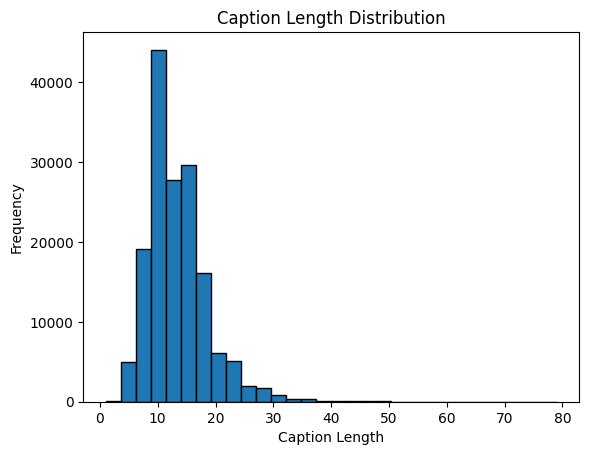

In [ ]:
import matplotlib.pyplot as plt

# Read captions from the file
with open('/content/flickr30k_data/captions.txt', 'r') as file:
    captions = file.readlines()

# Calculate caption lengths
caption_lengths = [len(caption.split()) for caption in captions]

# Create a histogram of caption lengths
plt.hist(caption_lengths, bins=30, edgecolor='black')
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.title('Caption Length Distribution')
plt.show()


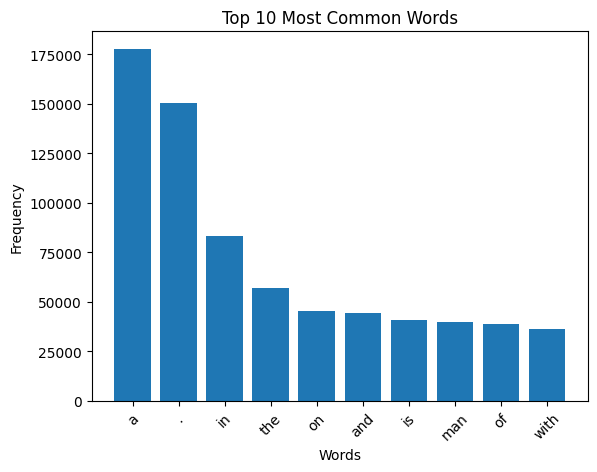

In [ ]:
from collections import Counter

# Combine all captions into a single list of words
all_words = ' '.join(captions).split()

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the top N most frequent words
top_n = 10
most_common_words = word_counts.most_common(top_n)

# Plot the most common words
plt.bar(*zip(*most_common_words))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Common Words')
plt.xticks(rotation=45)
plt.show()


In [ ]:
print("Number of captions:", len(captions))
print("Number of image files:", len(image_filenames))
print("Example caption:", captions[2])
print("Example image file:", image_dir[2])

Number of captions: 158916
Number of image files: 31783
Example caption: 1000092795.jpg,1,Two young  White males are outside near many bushes .

Example image file: o


In [ ]:
print("Number of captions:", len(text_data))
print("Number of image files:", len(caption_mapping))
# print("Example caption:", text_data[1])
# print("Example image file:", image_filenames[1])

Number of captions: 138537
Number of image files: 27430


In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

<ipython-input-24-dd1880e71766>:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_images = random.sample(caption_mapping.keys(), sample_size)


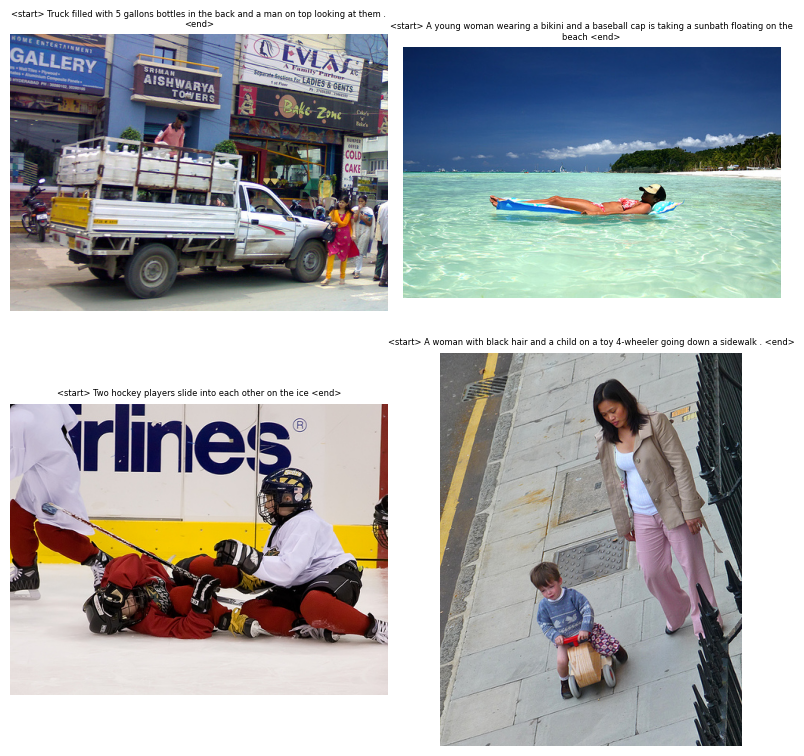

/content/flickr30k_data/flickr30k_images/2961320666.jpg


In [ ]:
base_image_dir = "/content/flickr30k_data/flickr30k_images"
sample_size = min(4, len(caption_mapping))
random_images = random.sample(caption_mapping.keys(), sample_size)

# Plot images and captions
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, img_path in enumerate(random_images):
    img_filename = os.path.basename(img_path)  # Extract the filename from the path
    img_full_path = os.path.join(base_image_dir, img_filename)  # Combine base directory with image filename
    img = mpimg.imread(img_full_path)
    captions = caption_mapping[img_path]
    caption = captions[0] if i < len(captions) else text_data[i - len(captions)]

    ax = axes[i // 2, i % 2]
    ax.imshow(img)
    ax.set_title(caption, fontsize=6, wrap=True)
    ax.axis('off')

plt.tight_layout()
plt.show()
print(img_full_path)

In [ ]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    print(all_images[0:10])

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)
    print(train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

In [ ]:
# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(caption_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

['flickr30k_data/1000092795.jpg', 'flickr30k_data/10002456.jpg', 'flickr30k_data/1000268201.jpg', 'flickr30k_data/1000344755.jpg', 'flickr30k_data/1000366164.jpg', 'flickr30k_data/1000523639.jpg', 'flickr30k_data/1000919630.jpg', 'flickr30k_data/10010052.jpg', 'flickr30k_data/1001465944.jpg', 'flickr30k_data/1001545525.jpg']
21944
Number of training samples:  21944
Number of validation samples:  5486


In [ ]:
print(train_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

#Remove punchuation
strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

In [ ]:
#vectorization.get_vocabulary()

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

Batching the image with text array

In [ ]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_full_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_full_path), vectorization(captions)

def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset

In [ ]:
# Pass the list of image paths and a corresponding list of captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

In [ ]:
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 25), dtype=tf.int64, name=None))>


Model Building

**CNN MODEL**-extract image features

**Transformer Encoder**-extracted features are passed to Transformer encoder that generates new representation of inputs

**Transformer Decoder**-takes the encoder output and text data as inputs and try to generate captions

In [ ]:
#IMAGE_SIZE = (224, 224)  # Replace with your desired image size

In [ ]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

In [ ]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers  # This line imports the layers module from Keras
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [ ]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            # Apply image augmentation using TensorFlow functions
            batch_img = tf.image.random_flip_left_right(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]

In [ ]:
EMBED_DIM = 256  # Replace with your desired embedding dimension
FF_DIM = 512  # Replace with your desired feedforward dimension
DENSE_DIM = 1024  # Replace with your desired value
SEQ_LENGTH = 50  # Replace with your desired sequence length
VOCAB_SIZE = 10000  # Replace with your desired vocabulary size
image_augmentation = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2)


In [ ]:
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
#for image_path, _ in train_dataset:
 #   print(image_path)


In [ ]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

686/686 [==============================] - 215s 266ms/step - loss: 21.9840 - acc: 0.2657 - val_loss: 20.0630 - val_acc: 0.3142


In [ ]:
caption_model.save_weights('model.h5')

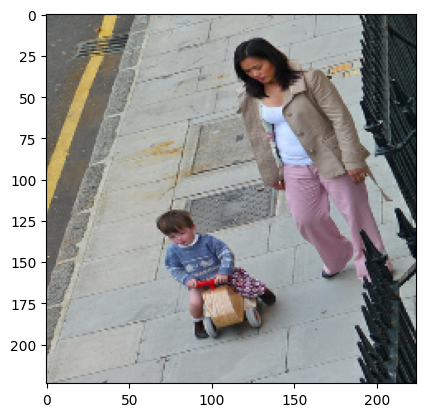

Predicted Caption: a man in a blue shirt and a red and a red and white dog


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

def generate_caption(sample_img):
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)
    encoded_img = caption_model.encoder(img, training=False)

    decoded_caption = "<start>"
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start>", "").replace("<end>", "").strip()
    return decoded_caption

# Generate captions for a few samples
for _ in range(1):
    # Select a random image from the validation dataset
    random_image_path = np.random.choice(valid_images)
    sample_img = decode_and_resize(random_image_path)
    plt.imshow(sample_img.numpy().clip(0, 255).astype(np.uint8))
    plt.show()

    predicted_caption = generate_caption(sample_img)
    print("Predicted Caption:", predicted_caption)

In [ ]:
from skimage import io

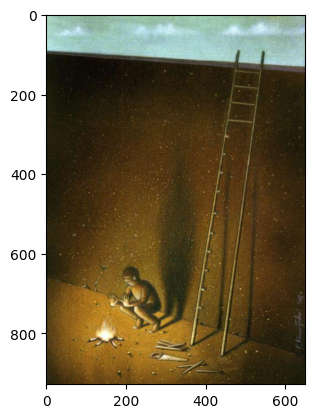

In [ ]:
image=io.imread("/content/broken-ladder-fire.jpg")
plt.imshow(image)
plt.show()

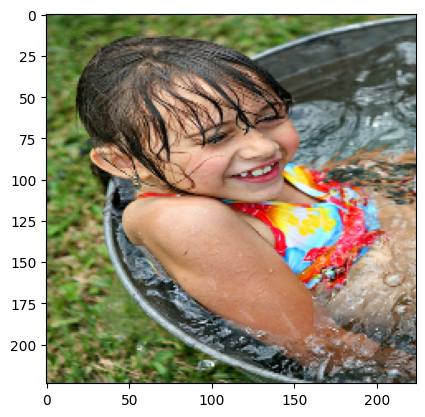

Predicted Caption: a man in a blue shirt is playing a guitar


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

def generate_caption(sample_img):
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)
    encoded_img = caption_model.encoder(img, training=False)

    decoded_caption = "<start>"
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start>", "").replace("<end>", "").strip()
    return decoded_caption

# Generate captions for a few samples
for _ in range(1):
    # Select a random image from the validation dataset
    sample_img = decode_and_resize("/content/broken-ladder-fire.jpg")
    plt.imshow(sample_img.numpy().clip(0, 255).astype(np.uint8))
    plt.show()

    predicted_caption = generate_caption(sample_img)
    print("Predicted Caption:", predicted_caption)